# AdPMCMC on model $M_0$ to $M_2$

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd


import scipy
from scipy.stats import invgamma
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

from tqdm import tqdm 

# Homemade functions
from utils import process_date, stratified_resampling, gaussian_kernel_density, equation
from trajectorySimulation import trajectory_simulation
from SMC import SMC
from AdPMCMC import AdPMCMC_M0, AdPMCMC_M2

Populating the interactive namespace from numpy and matplotlib


We begin by considering the model $M_0$ : 
\begin{equation}
\log N_{t+1} = \log N_t + b_0 + \epsilon_t
\end{equation}

with $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$. 

We put a Gaussian prior on the maximum per-individual growth rate parameter : $b_0 \sim \mathcal{N}(0, 1)$.
We use inverse Gamma priors for the variance noises :

$\sigma_\epsilon^2 \sim \mathcal{IG}(\alpha_\epsilon, \beta_\epsilon)$

$\sigma_w^2 \sim \mathcal{IG}(\alpha_w, \beta_w)$

with hyperpameters $\alpha_\epsilon=\alpha_w=\frac{T}{2}$ and $\beta_\epsilon=\beta_w=\frac{2(\alpha_\epsilon-1)}{10}$.

## MCMC kernel for $\theta$

In [2]:
from kernels import non_adaptive_theta_proposal, adaptive_theta_proposal

## SMC sampler for $n_{1:T}$

In the paper, there seems to be a simulation of $b_0$ per particles, see Algorithm 1, p.31, this seems odd.

See "Log-PF: Particle Filtering in Logarithm Domain" for log-normalization of weights
Need to check initialisation for other models than M_0

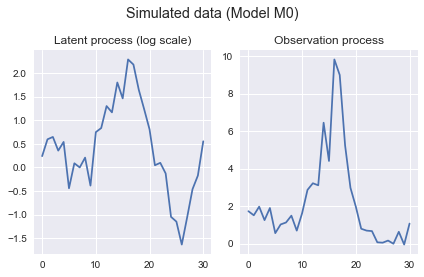

In [5]:
# Model choice and general model parameters
model = 'M0'
b_0 = 0.15
b_2 = -0.125
b_3 = 0.1
sigma_w = 0.39 # observation noise
sigma_eps = 0.47 # process noise
n_0 = 1.27 # starting point of latent variable
T = 30 # time horizon

# Simulate and plot a trajectory
log_N, Y = trajectory_simulation(model = model, T=T, n_0=n_0, b_0=b_0, b_2=b_2, b_3=b_3,
                                sigma_eps=sigma_eps, sigma_w=sigma_w)

f, (ax1, ax2) = plt.subplots(1, 2)
st = f.suptitle("Simulated data (Model {})".format(model), fontsize="x-large")

ax1.plot(log_N)
ax1.set_title('Latent process (log scale)')
ax2.plot(Y)
ax2.set_title('Observation process')

plt.tight_layout()

st.set_y(0.95)
f.subplots_adjust(top=0.80)

-40.799317746


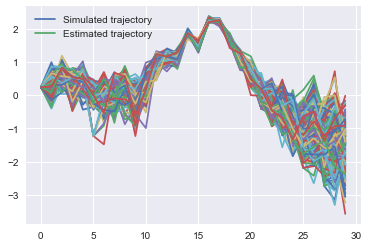

In [6]:
L = 200 # number of particles

log_particles, log_W, log_marginal_likelihood = SMC(Y, T, L, n_0,model,sigma_eps, sigma_w,B_0=b_0,B_2=b_2,B_3=b_3)

log_particles_averaged = [np.average(log_particles[t, :], weights=np.exp(log_W[t, :]), axis=0) 
                          for t in range(T)]

plt.plot(log_N[:-1])
plt.plot(log_particles) 
plt.legend(["Simulated trajectory", "Estimated trajectory"])
print(log_marginal_likelihood)

In [7]:
%load_ext line_profiler
%lprun -f SMC SMC(Y, T, L, n_0,model,sigma_eps, sigma_w,B_0=b_0,B_2=b_2,B_3=b_3)

## Stage 3 : Generic PMCMC

In [8]:
n_steps = 10000 # number of iterations 
L = 150 # number of particles
adaptive_rate = 0.5  # adaptive rate (set to 0 for non-adaptive proposal)

theta_hist_M0 = AdPMCMC_M0(n_steps, T, adaptive_rate, Y, L, n_0)

Running AdPMCMC: 100%|██████████| 10000/10000 [08:51<00:00, 18.83it/s]

Number of samples : 2241


In [9]:
theta_hist_M2 = AdPMCMC_M2(n_steps, T, adaptive_rate, Y, L, n_0)

Running AdPMCMC: 100%|██████████| 10000/10000 [08:09<00:00, 20.44it/s]


Number of samples : 2640


In [85]:
# burn-in time
theta_history_M0 = np.array(theta_hist_M0[1000:])
theta_history_M2 = np.array(theta_hist_M2[1000:])

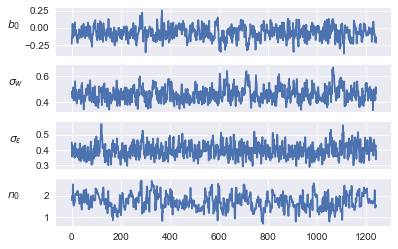

In [86]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot(theta_history_M0[:, 0])
axarr[0].set_ylabel(r'$b_0$', rotation=0, labelpad=10)
axarr[1].plot(theta_history_M0[:, 1])
axarr[1].set_ylabel(r'$\sigma_w$', rotation=0, labelpad=20)
axarr[2].plot(theta_history_M0[:, 2])
axarr[2].set_ylabel(r'$\sigma_\epsilon$', rotation=0, labelpad=20)
axarr[3].plot(theta_history_M0[:, 3])
axarr[3].set_ylabel(r'$n_0$', rotation=0, labelpad=30)
savefig('MCMC.png')

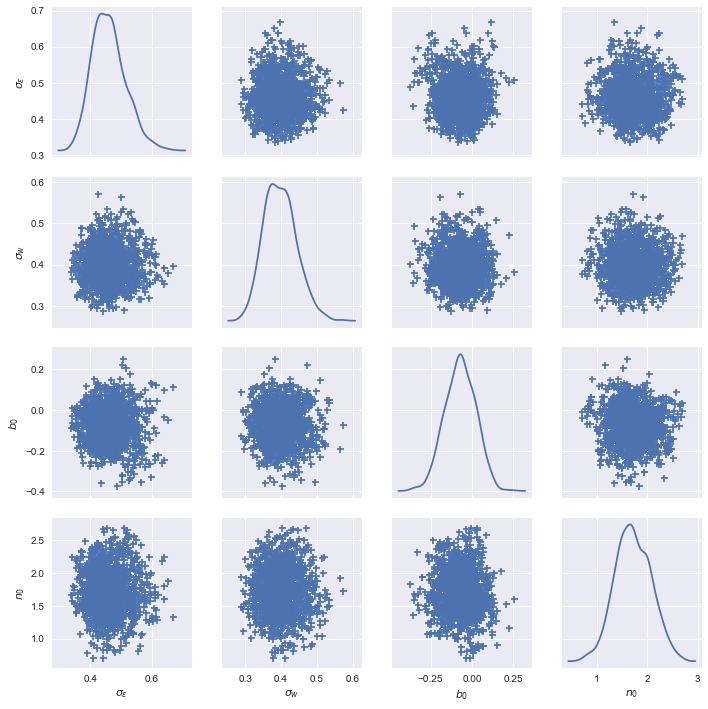

In [87]:
df_M0 = pd.DataFrame({r'$b_0$':theta_history_M0[:,0], r'$\sigma_\epsilon$':theta_history_M0[:,1],
                   r'$\sigma_w$':theta_history_M0[:,2], r'$n_0$':theta_history_M0[:,3]})

sns.pairplot(df_M0, diag_kind="kde", markers="+")
savefig('scatterplot_M0.png')

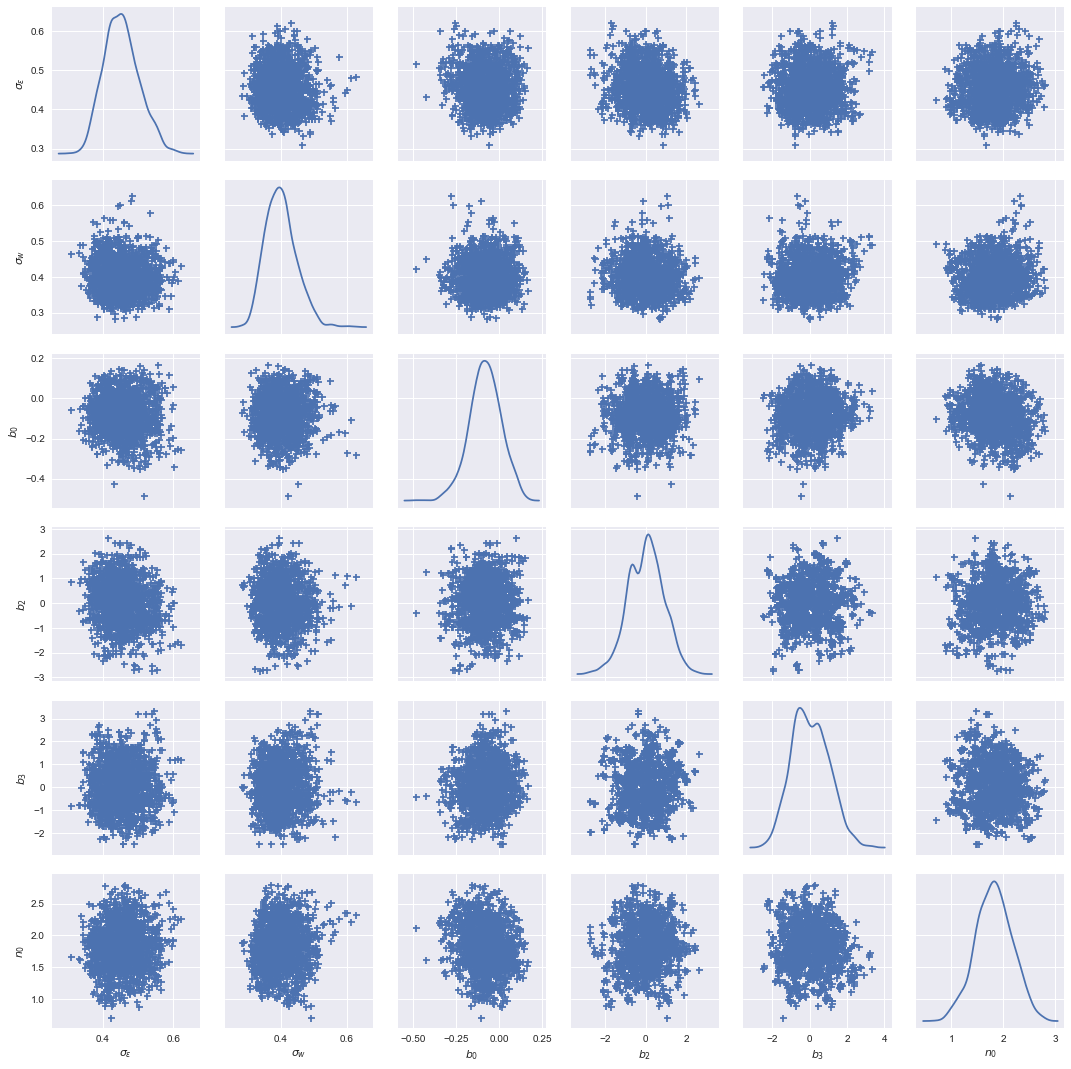

In [88]:
df_M2 = pd.DataFrame({r'$b_0$':theta_history_M2[:,0], r'$b_2$':theta_history_M2[:,1],
                      r'$b_3$':theta_history_M2[:,2], r'$\sigma_\epsilon$':theta_history_M2[:,3],
                   r'$\sigma_w$':theta_history_M2[:,4], r'$n_0$':theta_history_M2[:,5]})
sns.pairplot(df_M2, diag_kind="kde", markers="+")
savefig('scatterplot_M2.png')

# Real data

We load the nutria database and plot the trajcetory of the myocastor coypus population :

In [89]:
df = pd.read_csv('nutria_data.csv')
df['YearMonth'] = df['TimeOfSample'].apply(process_date)
df.head()

,TaxonName,MainID,TimeOfSample,Population,Abundance,YearMonth
0,Myocastor coypus,9833,1970.01,0.55,550,719163.0
1,Myocastor coypus,9833,1970.02,0.55,550,719194.0
2,Myocastor coypus,9833,1970.03,0.60,600,719222.0
3,Myocastor coypus,9833,1970.04,0.55,550,719253.0
4,Myocastor coypus,9833,1970.05,0.50,500,719283.0


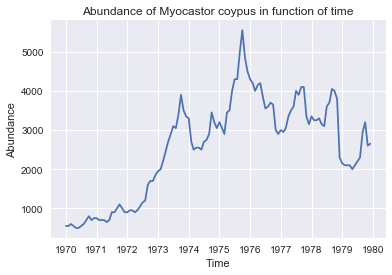

In [90]:
plt.plot_date(df["YearMonth"],df["Abundance"], '-')
plt.title('Abundance of Myocastor coypus in function of time')
plt.xlabel('Time')
plt.ylabel('Abundance')

120

-220.238104806


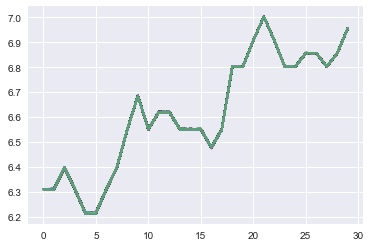

In [130]:
Y_nutria = df["Abundance"].tolist()
n_0_nutria = Y_nutria[0] 

#T = len(Y_nutria)
T = 30
L = 5000 # number of particles

b_0 = 0.5
sigma_eps = 0.42
sigma_w = 0.45

log_particles, log_W, log_marginal_likelihood = SMC(Y_nutria, T, L, n_0_nutria, 
                                                    'M', sigma_eps, sigma_w, B_0=b_0
                                                    , B_2=b_2, B_3=b_3)

#log_particles_averaged = [np.average(log_particles[t, :], weights=np.exp(log_W[t, :]), axis=0) 
#                          for t in range(T)]

plt.plot(log_particles)
print(log_marginal_likelihood)
#plt.plot(df["Abundance"])

In [ ]:
n_steps = 10000
L = 1000

# adaptive rate 
adaptive_rate = 0.5  # set to 0 -> non-adaptive proposal

theta_hist_nutria = AdPMCMC_M0(n_steps, T, adaptive_rate, Y_nutria, L, n_0_nutria)

Running AdPMCMC:  59%|█████▉    | 5935/10000 [32:56<22:33,  3.00it/s]

In [ ]:
# burn-in time
theta_history = np.array(theta_hist_nutria[0:])

plt.plot(theta_history[:, 0])